In [4]:
#####################################################################
## Install required packages
# ! pip install hdbscan
# ! pip install mat73
# ! pip install xlsxwriter
# ! pip install eli5
# ! pip install shap
# ! pip install -U ipykernel
# ! pip install mglearn
# ! pip install --upgrade pip setuptools wheel

In [1]:
#####################################################################
## Clear all variables in the memory
all = [var for var in globals() if var[0] != "_"]
for var in all:
    del globals()[var]

In [3]:
#####################################################################
## Import retuired packages
import numpy as np
import pandas as pd
from scipy.stats import mstats
from scipy.stats import mode
import random as rd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import mglearn
from scipy import stats

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift, OPTICS, cluster_optics_dbscan
from scipy.cluster.hierarchy import dendrogram, ward, linkage
from hdbscan import HDBSCAN

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn import metrics

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm
import matplotlib.ticker as ticker

import collections
idx = pd.IndexSlice

import openpyxl
import xlsxwriter
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')


In [79]:
# 많은 행이나 열을 보기위한 출력 표시
pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)

In [5]:
#####################################################################
## Settings for the calculations that can be changed
########################################################################

train_period = 1 # months for traing, must be larger than 0
HZ = 1  # Number of months to forecasting, months of lagged FC, must be larger than or equal to 0, forecasting_horizon
Minimum_Number_Stocks = 0.6   # Firm characteritics that are avvailable for at least x% of stocks
MicroCapLevel = 40 # The cut-off point of Micro-cap Stocks: bottom x% of KSE stocks
No_Layers = 1  # DNN
Upper_limit = 0.98       # FC upper outliers
Lower_limit = 1-Upper_limit  # FC lower outliers
Lags_Acc = 3  # the number of months for the release of acc information after acc year.


In [6]:
#####################################################################
# Winsorizing variables (to control outliers)
def winsorize_df(df):
    return df.apply(winsorize_series, axis=0)

def winsorize_series(s):
    return mstats.winsorize(s, limits=[1-Upper_limit, Lower_limit])

In [8]:
def PCA_P(df,n_components):
    pca = PCA(copy=True, iterated_power='auto' ,n_components= n_components , random_state=None, svd_solver='auto', tol=0.0, whiten=False)
    df = pd.DataFrame( pca.fit_transform(df))

    return df

In [83]:
# ########################################################################
# ## Get Data  구글 드라이버에서 데이터 읽는 경우 구글드라이버를 마운트해야함
# ########################################################################
from google.colab import drive
drive.mount('/gdrive')


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [7]:
########################################################################
## Get Data
########################################################################

## =====================================================================
## I. Market Macro Data - Monthly
## ---------------------------------------------------------------------

Macro_Variables = pd.read_excel(r'G:\내 드라이브\DATASET\ML_and_Financial_Forecasting\퀀트 시장경제데이터_월별.xlsx', sheet_name='시장데이터')   # 구글 드라이버에서 데이터 읽는 경우
# Macro_Variables = pd.read_excel("D:\\Qsync\\ACDSKK\\Lectures\\머신러닝과 경제예측2024\\data\\퀀트 시장경제데이터_월별.xlsx", sheet_name='시장데이터')
Dates = Macro_Variables['DATE'].dt.strftime('%Y%m').values
# Dates = pd.date_range(start='2000-01-31', end='2024-01-31', freq="M")
# Dates = Dates.strftime('%Y%m')
# Dates =  Dates.values

Macro_Variables = pd.DataFrame(Macro_Variables.iloc[:,1:])   # Remove dates
Macro_Variables.index = Dates


## ---------------------------------------------------------------------
# The Number of Months
## ---------------------------------------------------------------------

T = len(Macro_Variables)


## ---------------------------------------------------------------------
# Treatment of Market-wide Variables
## ---------------------------------------------------------------------

RET_Mkt = (Macro_Variables['KOSPI']-Macro_Variables['KOSPI'].shift(1))/Macro_Variables['KOSPI'].shift(1)*100
CS = Macro_Variables['BBB-'] - Macro_Variables['AA-'] # credit spread
TS = Macro_Variables['TB10Y'] - Macro_Variables['TB1Y'] # term spread
SP500 = (Macro_Variables['SP500']-Macro_Variables['SP500'].shift(1))/Macro_Variables['SP500'].shift(1)*100   # S&P500 return
CN = (Macro_Variables['CN']-Macro_Variables['CN'].shift(1))/Macro_Variables['CN'].shift(1)*100   # Shanghai Index return
IPI = (Macro_Variables['IPI'].shift(1)-Macro_Variables['IPI'].shift(2))/Macro_Variables['IPI'].shift(2)*100   # Industrial Production, one month lagged
# IPI 산업생산지수
CD = Macro_Variables['CD']  # CD rate
KVIX = Macro_Variables['KVIX']  # Option Implied Volatility


## ---------------------------------------------------------------------
## Market Variables for the Prediction of Returns
## ---------------------------------------------------------------------
# Test Variables  - No Macro variables
Macro_Variables = pd.DataFrame(np.ones(T), columns = ['const'], index=Dates)
Macro_Variable_names = Macro_Variables.columns

# # Test Variables  - with Macro-variables
# Macro_Variables = pd.concat([IPI], axis=1)
# Macro_Variables.columns = ['IPI']
# Macro_Variables = pd.DataFrame(sm.add_constant(Macro_Variables))
# Macro_Variable_names = Macro_Variables.columns

## ---------------------------------------------------------------------
# Confirm Macro Variables for the prediction of returns
## ---------------------------------------------------------------------

print(Macro_Variables )
print(Macro_Variable_names )



        const
200001    1.0
200002    1.0
200003    1.0
200004    1.0
200005    1.0
...       ...
202309    1.0
202310    1.0
202311    1.0
202312    1.0
202401    1.0

[289 rows x 1 columns]
Index(['const'], dtype='object')


In [9]:
## =====================================================================
## II. Individual Stock Market Data - Monthly
## ---------------------------------------------------------------------

## ---------------------------------------------------------------------
## Reading Market Data
## ---------------------------------------------------------------------

FC_M = pd.read_excel(r"G:\내 드라이브\DATASET\ML_and_Financial_Forecasting\퀀트 개별기업시장데이터_월별.xlsx", sheet_name = None, header=0)   # 구글 드라이버에서 데이터 읽는 경우
# FC_M = pd.read_excel("D:\\Qsync\\ACDSKK\\Lectures\\머신러닝과 경제예측2024\\data\\퀀트 개별기업시장데이터_월별.xlsx", sheet_name = None, header=0)
FC_M_Variable_Names = list(FC_M.keys())   # names of variables


## ---------------------------------------------------------------------
## Calculation of Returns
## ---------------------------------------------------------------------

ret = FC_M['ret']      # in percent
Dates_ret = ret.iloc[:,0].dt.strftime('%Y%m').values
if np.array_equal(Dates,Dates_ret):
    ret = ret.iloc[:,1:]/100    # in decimal
    ret.index = Dates
    Firm_Names = ret.columns
    # ret.columns = range(0, 3537)

## Returns that are used to be forecasted
RET = ret # returns of individual stocks at time t
if HZ>1:
    for hz in range(1,HZ):
        RET = (1+RET)*(1+ret.shift(hz))-1    # shift 양수는 과거 (lag), 음수는 미래
RET.index = Dates
RET = RET*100


## ---------------------------------------------------------------------
## The Number of Stocks
## ---------------------------------------------------------------------

N = len(ret.T)


## ---------------------------------------------------------------------
## Entire Individual Stock Market Data in the form of T by N  -  remioving the first column (dates)
## ---------------------------------------------------------------------

for fc_m in FC_M_Variable_Names:
    Ind_Var = FC_M[fc_m]
    Ind_Var_Dates = Ind_Var.iloc[:,0].dt.strftime('%Y%m').values
    if not np.array_equal(Dates,Ind_Var_Dates):
        print([fc_m+" : Dates of Macro Data and Individual Stock Data Do Not Match!"])
    else:
        FC_M[fc_m] = Ind_Var.iloc[:,1:]
        FC_M[fc_m].index = Dates


## ---------------------------------------------------------------------
## Variables for the Prediction of Returns
## ---------------------------------------------------------------------

FC_M['trad_ind'] = pd.DataFrame(FC_M['trad_ind']/FC_M['tvolm']*10000/100)    # in percent
# 개인투자자순매매 비중
# FC_M['trad_ind'].index = Dates

FC_M['trad_institution'] = pd.DataFrame(FC_M['trad_institution']/FC_M['tvolm']*10000/100)    # in percent
# 기관투자 순매매 비중
# FC_M['trad_institution'].index = Dates

FC_M['trad_foreign'] = pd.DataFrame(FC_M['trad_foreign']/FC_M['tvolm']*10000/100)    # in percent
# 외국인투자 순매매 비중
# FC_M['trad_foreign'].index = Dates

FC_M['tvolm'] = pd.DataFrame(FC_M['tvolm']/FC_M['m_value']/1000000*100)  # in percent
# 거래액/시가총액
# FC_M['tvolm'].index = Dates

FC_M['short_int'] = pd.DataFrame(FC_M['short_int']/FC_M['shrout']*100)   # in percent
# short interest 숏 잔고/ 발행주식 총 수
# FC_M['short_int'].index = Dates

# Age (years) since IPO in years
TT1 = np.trunc(FC_M['ipo_date']/10000)
TT3 = np.trunc((Dates.astype(float))/100)
TT2 = np.empty((T,N),)
for i in range(0,N):
    TT2[:,i] = TT3 - TT1.iloc[:,i]
FC_M['ipo_date'] = pd.DataFrame(np.where(TT2 <= 0, np.nan, TT2), index=Dates)
FC_M['age'] = FC_M.pop('ipo_date')
FC_M['age'].columns =Firm_Names

FC_M['m_value'] = pd.DataFrame(FC_M['m_value'])
# FC_M['m_value'].index = Dates

FC_M['anal_rating'] = pd.DataFrame(FC_M['anal_rating'])
# FC_M['anal_rating'].index = Dates


## ---------------------------------------------------------------------
## Saved for other calculations
## ---------------------------------------------------------------------

# nominal price
PRC = FC_M.pop('price')

TVOLM = FC_M['tvolm']  # in percent
M_VALUE = FC_M['m_value']

# total number of shares
SHROUT =pd.DataFrame(FC_M['shrout'], index=Dates)

# Micro-cap stocks
microcapind = pd.DataFrame(np.zeros((T,N)), index=Dates)
for t in range(0,T):
    microcapind.iloc[t,(FC_M['m_value'].iloc[t,:] < stats.scoreatpercentile(FC_M['m_value'].iloc[t,:].replace(0,np.nan).dropna(),MicroCapLevel))] = 1   # 하위 MicroCapLevel 보다 적은 모든 주식
    microcapind.iloc[t,(ret.iloc[t-11:t,:]==0).sum()>2] = 1     # 거래월수가 없는 달이 3달 이상이면   사용하지 않음

# ## ---------------------------------------------------------------------
# ## Remove Variables in FC_M that are not used for the prediction of returns
# ## ---------------------------------------------------------------------

for fc_m in list(FC_M):
    if fc_m in ['acc_year', 'shrout']:
        del FC_M[fc_m]

## ---------------------------------------------------------------------
## Saved Firm Characteristics Variables for the prediction of returns
## ---------------------------------------------------------------------

print(FC_M.keys())
print(FC_M['m_value'])

dict_keys(['ret', 'tvolm', 'm_value', 'short_int', 'anal_rating', 'trad_institution', 'trad_ind', 'trad_foreign', 'age'])
        A000020    A000030  A000040  A000050  A000060  A000070    A000080  \
200001    75523  2549174.0     7119    38743  96954.0   144783    52626.0   
200002    78255  1749005.0     6472    39381  82368.0   172144    52626.0   
200003    82903  1512889.0     6903    47034  75418.0   140223    44570.0   
200004    61778  1473536.0     6687    41055  50021.0   150483    38982.0   
200005    48841  1657182.0     5339    37308  51909.0   111152    40282.0   
...         ...        ...      ...      ...      ...      ...        ...   
202309   273728        NaN    82006   232481      NaN   597786  1324824.0   
202310   270656        NaN    49511   218226      NaN   581514  1490339.0   
202311   265628        NaN    48838   236868      NaN   594360  1549953.0   
202312   286856        NaN    34418   242351      NaN   590935  1578006.0   
202401   269539        NaN    3

In [86]:
## =====================================================================
## III. Individual Stock Accounting Data - Monthly
## ---------------------------------------------------------------------
## FC_M에 있는 market data ('tvolm', 'm_value', 'short_int', 'anal_rating', 'trad_institution', 'trad_ind', 'trad_foreign', 'age')에 다음 회계항목을 추가

## 모든 재무상태표 항목은 자산은 1로 표준화되어 있음, 자산만 금액으로 표시
Acc_BS_Items = pd.read_excel("/gdrive/MyDrive/머신러닝과 경제예측2024/data/퀀트_S_Acc_BS.xlsx", sheet_name = None, index_col=0)       # 구글 드라이버에서 데이터 읽는 경우
# Acc_BS_Items = pd.read_excel("D:\\Qsync\\ACDSKK\\Lectures\\머신러닝과 경제예측2024\\data\\퀀트_S_Acc_BS.xlsx", sheet_name = None, index_col=0)
Acc_BS_Items_D = {}
Items = list(Acc_BS_Items.keys())
for k in Items:
    Acc_BS_Items[k] = Acc_BS_Items[k].shift(12+Lags_Acc)
    Acc_BS_Items_D[k+'_D'] = Acc_BS_Items[k].shift(12+Lags_Acc) - Acc_BS_Items[k].shift(12+12+Lags_Acc)
FC_M.update(Acc_BS_Items)
FC_M.update(Acc_BS_Items_D)

## 모든 이익계산서 항목은 매출을 1로 표준화되어 있음, 매출액만 금액으로 표시
Acc_IS_Items = pd.read_excel("/gdrive/MyDrive/머신러닝과 경제예측2024/data/퀀트_S_Acc_IS.xlsx", sheet_name = None, index_col=0)        # 구글 드라이버에서 데이터 읽는 경우
# Acc_IS_Items = pd.read_excel("D:\\Qsync\\ACDSKK\\Lectures\\머신러닝과 경제예측2024\\data\\퀀트_S_Acc_IS.xlsx", sheet_name = None, index_col=0)
Acc_IS_Items_D = {}
Items = list(Acc_IS_Items.keys())
for k in Items:
    Acc_IS_Items[k] = Acc_IS_Items[k].shift(12+Lags_Acc)
    Acc_IS_Items_D[k+'_D'] = Acc_IS_Items[k].shift(12+Lags_Acc) - Acc_IS_Items[k].shift(12+12+Lags_Acc)
FC_M.update(Acc_IS_Items)
FC_M.update(Acc_IS_Items_D)

## 매출과 자산과의 비율
FC_M['매출액_자산'] = FC_M['매출액']/FC_M['자산']
FC_M['매출액_자산_D'] = FC_M['매출액_자산'] - FC_M['매출액_자산'].shift(12)

FC_M['자산'] = np.log1p(FC_M['자산'])
FC_M['매출액'] = np.log1p(FC_M['매출액'])

## 전체 데이터 항목 확인
print(len(FC_M.keys()))
print(FC_M.keys())

125
dict_keys(['ret', 'tvolm', 'm_value', 'short_int', 'anal_rating', 'trad_institution', 'trad_ind', 'trad_foreign', 'age', '기타유형자산', '단기차입금', '대출채권', '매출채권', '무형자산', '미수금', '부채', '비유동부채', '사채1', '산업재산권', '설비자산', '순운전자본', '영업고정자산', '영업권', '우선주', '유동부채', '유동성장기부채', '유동자산', '유보액', '유형자산', '이연법인세자산', '이익잉여금', '자기주식', '자본', '장기금융자산', '장기미지급금', '장기차입금', '재고자산', '전환사채', '주식발행초과금', '토지', '현금및현금성자산', '기타유형자산_D', '단기차입금_D', '대출채권_D', '매출채권_D', '무형자산_D', '미수금_D', '부채_D', '비유동부채_D', '사채1_D', '산업재산권_D', '설비자산_D', '순운전자본_D', '영업고정자산_D', '영업권_D', '우선주_D', '유동부채_D', '유동성장기부채_D', '유동자산_D', '유보액_D', '유형자산_D', '이연법인세자산_D', '이익잉여금_D', '자기주식_D', '자본_D', '장기금융자산_D', '장기미지급금_D', '장기차입금_D', '재고자산_D', '전환사채_D', '주식발행초과금_D', '토지_D', '현금및현금성자산_D', '매출액', '감가상각비', '관리비', '광고선전비', '당기순손익', '대손상각비(판관비)', '매출원가', '매출총이익(손실)', '무형자산상각비', '법인세비용', '복리후생비', '부가가치', '영업외비용', '영업외수익', '영업이익(손실)', '유무형자산상각비', '유형자산감가상각비', '인건비', '임차료', '자기주식처분손익', '재평가손익', '퇴직급여', '판매비', '판매비와관리비', '자산', '매출액_D', '감가상각비_D', '관리비_D', '광고

In [87]:
#####################################################################
# Data Treatment
#####################################################################


# for sdate in range(len(Dates)-5, len(Dates)):
# for sdate in range(train_period + HZ, len(Dates)):   # 전기간
for sdate in range(len(Dates)-1, len(Dates)):
    print(Dates[sdate])

    ss_ret = pd.DataFrame()
    NFCSS = pd.DataFrame()
    NFFCSS = pd.DataFrame()


    for t in range(sdate - train_period +1, sdate+1):   # past train_period

        # Traninging and validation data
        s_ret = RET.iloc[t,:].dropna()
        ST = s_ret.index
        ss_ret = pd.concat([ss_ret,s_ret])

        FC = pd.DataFrame()
        NFCSSm = pd.DataFrame()

        for fname in list(FC_M.keys()):
            temp = FC_M[fname]
            # temp.columns = range(0,len(temp.T))
            FC[fname] =  temp[ST].iloc[t] # Remove firms whose returns are not available

        # remoce unnecessary frim characteristics like return and price.
        # FCS = FC.drop(['ret', 'prc','Mkt','microcapind', 'shrout', 'FGSC', 'tvolm'], axis=1)
        # FCS = FC.loc[:,['매출액','영업이익(손실)_D']]   # specify FCs
        FCS = FC.drop(['ret'], axis=1)

        #####################################################################
        # Winsorizing and Normalising FC (to control outliers)
        WFCS = winsorize_df(FCS)
        NFCSt = (WFCS-np.mean(WFCS))/np.std(WFCS)

        NFCSS = pd.concat([NFCSS, NFCSt],axis=0)  # Clustering for firm characteristics
        # NFCSS = pd.concat([NFCSS, NFCSt],axis=1)   # clustering for stocks

     #####################################################################
    # Selection of Firm Characteristics that are available more than the least Minimum_Number_Stocks
     #####################################################################
    # Clustering for firm characteristics
    SST = ss_ret.index
    Total_FC = NFCSS
    Selected_FC = NFCSS.notnull().sum() >= Minimum_Number_Stocks * len(SST)
    NFCSS = NFCSS.loc[:, Selected_FC]

    # Replacing NA  to 0
    NFCSS = NFCSS.fillna(0)
    NFCSS_name_O = NFCSS.columns

    Col_Name = []
    for k in range(0,len(NFCSS.T)):
        Col_Name.append("FC"+str(k))
        print("FC"+str(k+1), NFCSS_name_O[k])
    NFCSS_name = Col_Name
    NFCSS.columns = Col_Name




202401
FC1 tvolm
FC2 m_value
FC3 short_int
FC4 trad_institution
FC5 trad_ind
FC6 trad_foreign
FC7 age
FC8 기타유형자산
FC9 단기차입금
FC10 매출채권
FC11 무형자산
FC12 부채
FC13 비유동부채
FC14 산업재산권
FC15 설비자산
FC16 순운전자본
FC17 영업고정자산
FC18 유동부채
FC19 유동성장기부채
FC20 유동자산
FC21 유보액
FC22 유형자산
FC23 이연법인세자산
FC24 이익잉여금
FC25 자기주식
FC26 자본
FC27 장기금융자산
FC28 재고자산
FC29 주식발행초과금
FC30 토지
FC31 현금및현금성자산
FC32 기타유형자산_D
FC33 단기차입금_D
FC34 매출채권_D
FC35 무형자산_D
FC36 미수금_D
FC37 부채_D
FC38 비유동부채_D
FC39 산업재산권_D
FC40 설비자산_D
FC41 순운전자본_D
FC42 영업고정자산_D
FC43 영업권_D
FC44 유동부채_D
FC45 유동자산_D
FC46 유보액_D
FC47 유형자산_D
FC48 이연법인세자산_D
FC49 이익잉여금_D
FC50 자기주식_D
FC51 자본_D
FC52 장기금융자산_D
FC53 재고자산_D
FC54 주식발행초과금_D
FC55 토지_D
FC56 현금및현금성자산_D
FC57 매출액
FC58 대손상각비(판관비)
FC59 매출원가
FC60 매출총이익(손실)
FC61 영업이익(손실)
FC62 자산
FC63 매출액_D
FC64 감가상각비_D
FC65 광고선전비_D
FC66 대손상각비(판관비)_D
FC67 무형자산상각비_D
FC68 법인세비용_D
FC69 자산_D
FC70 매출액_자산
FC71 매출액_자산_D


Principal Component Analysis Results
Eigen_Values
[8.01147276e-02 5.70134529e-02 5.45717786e-02 4.90920902e-02
 4.60193568e-02 3.75439462e-02 3.09930322e-02 2.96742948e-02
 2.60179537e-02 2.58501940e-02 2.40641509e-02 2.26331785e-02
 2.11094564e-02 2.05273903e-02 1.97581903e-02 1.85837311e-02
 1.80917325e-02 1.72676668e-02 1.68636654e-02 1.61264731e-02
 1.56332969e-02 1.54735541e-02 1.48194939e-02 1.47310793e-02
 1.44050613e-02 1.42366214e-02 1.38281670e-02 1.29054429e-02
 1.25777453e-02 1.24412610e-02 1.21355764e-02 1.18782652e-02
 1.17901443e-02 1.17573938e-02 1.12313166e-02 1.09661271e-02
 1.05768831e-02 9.94314164e-03 9.24919987e-03 9.16489771e-03
 8.48594044e-03 8.00290701e-03 7.47952216e-03 6.95306027e-03
 6.81904213e-03 6.74834902e-03 6.24133723e-03 6.13643113e-03
 5.73896155e-03 5.45584495e-03 5.25263408e-03 4.94124022e-03
 4.75834361e-03 4.32035874e-03 3.85833262e-03 3.75875728e-03
 3.49686640e-03 2.93425335e-03 2.60882329e-03 2.28945377e-03
 2.11439920e-03 2.09496679e-03 1.93

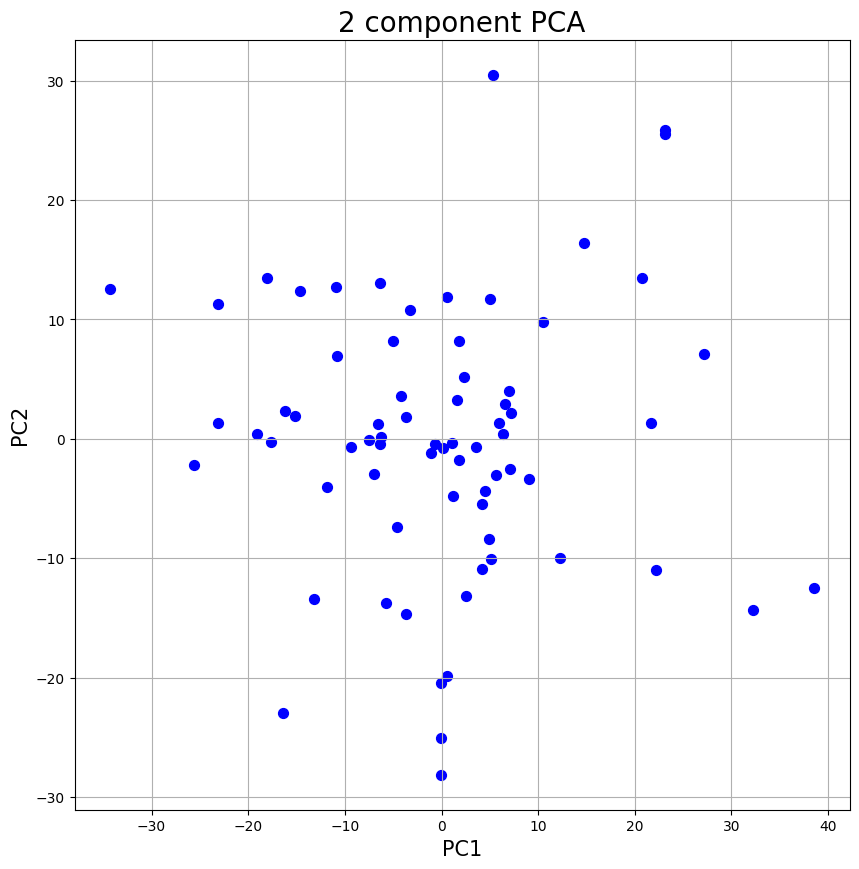

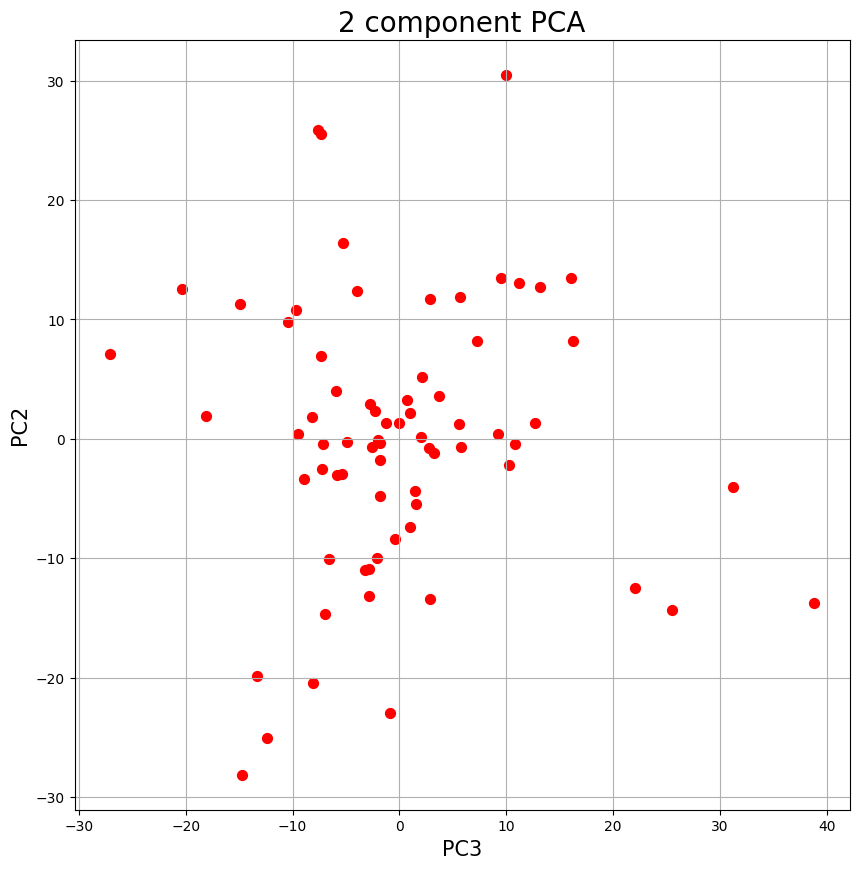

In [88]:
########################################################################
#  Principal Component Analysis
########################################################################

PCA_FCS = PCA(n_components= len(NFCSS.T))
# PCA_Results = PCA_FCS.fit_transform(NFCSS)      # Clustering for firms
PCA_Results = PCA_FCS.fit_transform(NFCSS.T)      # Clustering for firm characteristics
No_PC = np.cumsum(PCA_FCS.explained_variance_/sum(PCA_FCS.explained_variance_))
Col_Name = []
for k in range(1,len(No_PC)+1):  Col_Name.append("PC"+str(k))
PCA_FCS_R = pd.DataFrame(PCA_Results, columns = Col_Name)


print("================================================================")
print("Principal Component Analysis Results")
print("Eigen_Values")
print(PCA_FCS.explained_variance_/sum(PCA_FCS.explained_variance_))
print(np.cumsum(PCA_FCS.explained_variance_/sum(PCA_FCS.explained_variance_)))
print("Eigen_Vectors")
print(PCA_FCS_R)

fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('2 component PCA', fontsize=20)
ax.scatter(PCA_FCS_R.loc[:, 'PC1'], PCA_FCS_R.loc[:, 'PC2'], c = 'b', s = 50)
ax.grid()
plt.show()

fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('PC3', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('2 component PCA', fontsize=20)
ax.scatter(PCA_FCS_R.loc[:, 'PC3'], PCA_FCS_R.loc[:, 'PC2'], c = 'r', s = 50)
ax.grid()
plt.show()



In [89]:
############ Unsupervised Learning ########

# 1. K-Means Clustering

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(NFCSS.T)


##################################################
The number of FCs to Clusters:  Counter({9: 15, 0: 13, 1: 13, 4: 7, 3: 6, 8: 4, 2: 4, 5: 4, 6: 3, 7: 2})
Assignment of FCs to Clusters
[0 3 3 9 1 0 9 9 4 8 0 4 4 0 6 8 6 4 9 1 2 6 9 2 9 2 0 8 1 9 1 9 4 9 0 9 4
 0 0 5 9 5 0 4 1 1 5 9 1 0 1 0 9 1 5 1 3 9 9 0 2 3 3 7 1 1 7 0 3 8 1]


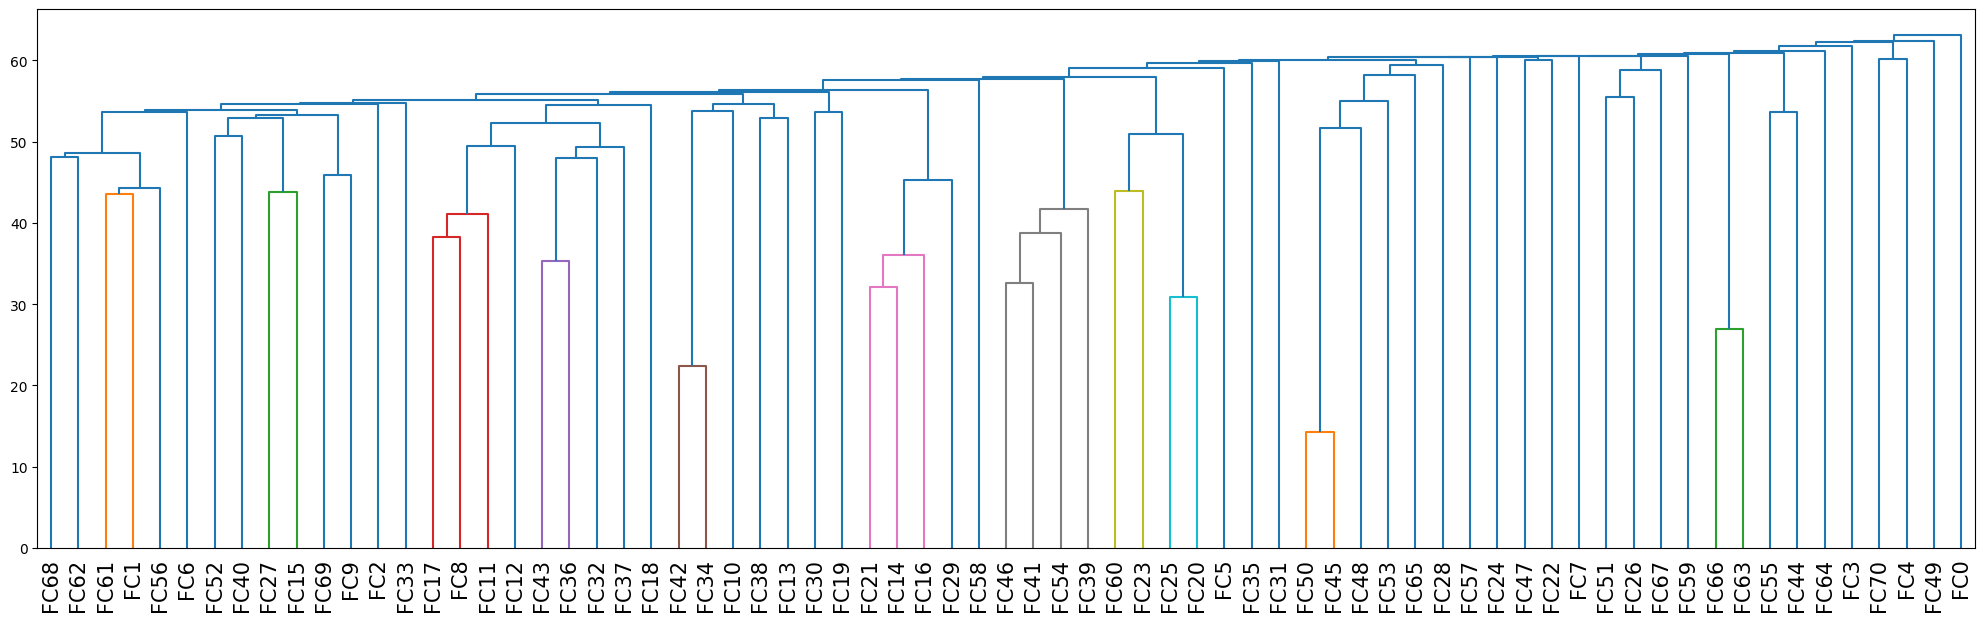

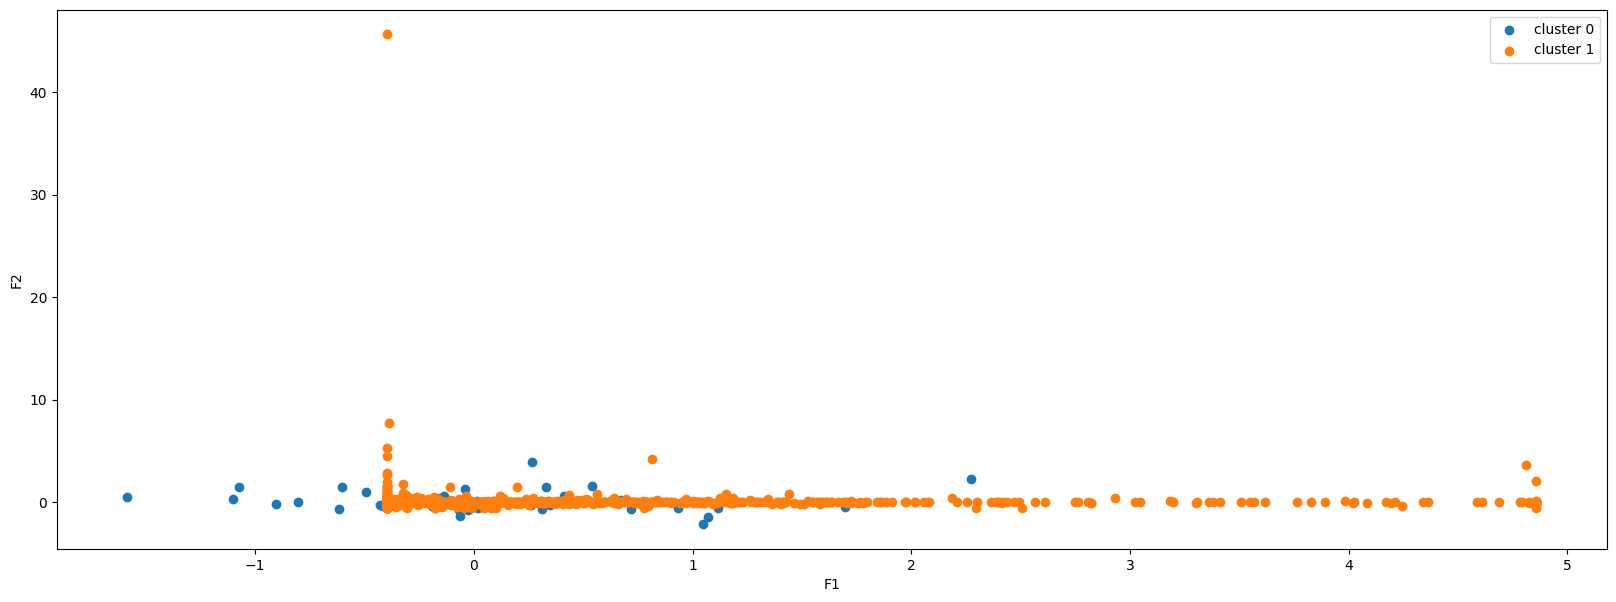

In [90]:
############ Unsupervised Learning ########

# 2. AgglomerativeClustering

# AGG = AgglomerativeClustering(distance_threshold=100, affinity='euclidean', n_clusters=None)
AGG = AgglomerativeClustering(n_clusters=10)
AGG_fit = AGG.fit(NFCSS.T)
AGG_labels = AGG_fit.labels_
AGG_FCS = pd.Series(data= AGG_labels )

print("##################################################")
print("The number of FCs to Clusters: "  ,collections.Counter(AGG_fit.labels_))
print("Assignment of FCs to Clusters")
print(AGG.fit_predict(NFCSS.T))

linked = linkage(NFCSS.T, 'single')
labelList = NFCSS.columns

plt.figure(figsize=(25, 7))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            leaf_font_size=15,
            show_leaf_counts=True)
plt.show()

#  For Two FCs

plt.figure(figsize=(20, 7))
assignment = AGG.fit_predict(NFCSS.T)   # Stocks (firms)
plt.scatter(NFCSS.iloc[0,:].T, NFCSS.iloc[1,:].T)
assignment = AGG.fit_predict(NFCSS)     # Firm characteristics
plt.scatter(NFCSS.iloc[:,7].T, NFCSS.iloc[:,65].T)
plt.legend(["cluster 0", "cluster 1"], loc="best")
plt.xlabel("F1")
plt.ylabel("F2")
plt.show()

In [91]:

# 3. DBSCAN Clustering

DBS = DBSCAN(eps=50, min_samples=3)
DBS_fit = DBS.fit(NFCSS.T)
DBS_labels = DBS_fit.labels_
DBS_FCS = pd.Series(data= DBS_labels )
DBS_FCS = pd.Series(index=NFCSS.columns, data= DBS_labels )
print("DBS: "  ,collections.Counter(DBS_fit.labels_))
print(DBS_FCS)



DBS:  Counter({-1: 50, 0: 5, 1: 4, 2: 4, 3: 4, 4: 4})
FC0    -1
FC1     0
FC2    -1
FC3    -1
FC4    -1
FC5    -1
FC6    -1
FC7    -1
FC8     1
FC9    -1
FC10   -1
FC11    1
FC12    1
FC13   -1
FC14    2
FC15   -1
FC16    2
FC17    1
FC18   -1
FC19   -1
FC20   -1
FC21    2
FC22   -1
FC23   -1
FC24   -1
FC25   -1
FC26   -1
FC27   -1
FC28   -1
FC29    2
FC30   -1
FC31   -1
FC32    3
FC33   -1
FC34   -1
FC35   -1
FC36    3
FC37    3
FC38   -1
FC39    4
FC40   -1
FC41    4
FC42   -1
FC43    3
FC44   -1
FC45   -1
FC46    4
FC47   -1
FC48   -1
FC49   -1
FC50   -1
FC51   -1
FC52   -1
FC53   -1
FC54    4
FC55   -1
FC56    0
FC57   -1
FC58   -1
FC59   -1
FC60   -1
FC61    0
FC62    0
FC63   -1
FC64   -1
FC65   -1
FC66   -1
FC67   -1
FC68    0
FC69   -1
FC70   -1
dtype: int64


In [92]:
# 4. HDBSCAN Clustering

HDBS = HDBSCAN(min_cluster_size=3,  metric = 'euclidean')
HDBS_fit = HDBS.fit(NFCSS.T)
HDBS_labels = HDBS_fit.labels_
HDBS_FCS = pd.Series(index=NFCSS.columns, data= HDBS_labels )
print("HDB:"  ,collections.Counter(HDBS.labels_))
print(HDBS_FCS)

HDB: Counter({0: 37, -1: 30, 1: 4})
FC0    -1
FC1     0
FC2    -1
FC3    -1
FC4    -1
FC5    -1
FC6    -1
FC7    -1
FC8     0
FC9     0
FC10    0
FC11    0
FC12    0
FC13    0
FC14    0
FC15    0
FC16    0
FC17    0
FC18    0
FC19    0
FC20   -1
FC21    0
FC22   -1
FC23    0
FC24   -1
FC25   -1
FC26   -1
FC27    0
FC28   -1
FC29    0
FC30   -1
FC31   -1
FC32    0
FC33    0
FC34    0
FC35    0
FC36    0
FC37   -1
FC38   -1
FC39    0
FC40    0
FC41    0
FC42   -1
FC43    0
FC44   -1
FC45    1
FC46    0
FC47   -1
FC48    1
FC49   -1
FC50    1
FC51    0
FC52    0
FC53    1
FC54    0
FC55   -1
FC56    0
FC57   -1
FC58    0
FC59   -1
FC60    0
FC61    0
FC62    0
FC63   -1
FC64   -1
FC65   -1
FC66   -1
FC67   -1
FC68    0
FC69    0
FC70   -1
dtype: int64


In [93]:
# # 5. Neural Networks for Unsupervised Learning
# # Autoencoders: Neural networks designed for dimensionality reduction or feature learning by learning to compress and decompress data.
# # Generative Adversarial Networks (GANs): A class of machine learning frameworks designed by two neural networks, the generator and the discriminator, against each other.

# input_img = Input(shape=(784,))
# encoded = Dense(128, activation='relu')(input_img)
# decoded = Dense(784, activation='sigmoid')(encoded)

# autoencoder = Model(input_img, decoded)
# autoencoder.compile(optimizer='adam', loss='binary_crossentropy')